# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb
import matplotlib.pyplot as plt
import utils
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from warnings import filterwarnings;filterwarnings('ignore')
pd.options.display.float_format = '{:0.2f}'.format

asl = AslDb() # initializes the database
#asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

##### Try it!

In [3]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
grnd=dict()
grnd['lx']=('left','x')
grnd['ly']=('left','y')
grnd['rx']=('right','x')
grnd['ry']=('right','y')
#collect the features in a list
features_ground=features_list('grnd')
for k,v in grnd.items():
    asl.df['grnd-'+k]=asl.df[v[0]+'-'+v[1]] - asl.df['nose-'+v[1]]
    # test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-lx  grnd-ly  grnd-rx  grnd-ry  
video frame                                      
98    0          -12      119        9      113  
      1          -12      119        9      113  
      2          -12      119        9      113  
      3          -12      119        9      113  
      4          -12      119        9      113

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [5]:
training_ground = asl.build_training(features_ground)
print("Training words: {}".format(training_ground.words))

Training words: ['BILL', 'SHOOT', 'VIDEOTAPE', 'GIVE', 'HOMEWORK', 'SAY', 'WHO', 'MARY', 'LIKE', 'MANY', 'STUDENT', 'WRITE', 'MOTHER', 'BROCCOLI', 'GIVE1', 'CHICKEN', 'MAN', 'WANT', 'ALL', 'BUT', 'CAR', 'GIVE3', 'HOUSE', 'WOMAN', 'JANA', 'SELL', 'BOY', 'TEACHER', 'SHOULD', 'BOX', 'FRIEND', 'PEOPLE', 'HAVE', 'FRED', 'NEW', 'IX', 'FISH', 'NEXT-WEEK', 'GIRL', 'THROW', 'LEG', 'LOVE', 'FINISH', 'GO1', 'LAST-WEEK', 'POSS', 'SAY-1P', 'YESTERDAY', 'BUY', 'ANN', 'CHOCOLATE', 'SUE', 'APPLE', 'PUTASIDE', 'FUTURE', 'CAN', 'NEW-YORK', 'COAT', 'JOHN', 'VEGETABLE', 'BUY1', 'SOMETHING-ONE', 'GO', 'TELL', 'PAST', 'SEARCH-FOR', 'TOY1', 'TOMORROW', 'THINK', 'SEE', 'BORROW', 'CANDY', 'CORN', 'LIVE', 'WHAT', 'CHICAGO', 'ARRIVE', 'SELF', 'NAME', 'GO2', 'BOOK', 'NOT', 'GET', 'EAT', 'MOVIE', 'READ', 'WONT', 'BLAME', 'FRANK', 'LEAVE', 'TOY', 'HIT', 'PARTY', 'BLUE', 'GROUP', 'STOLEN', 'PREFER', 'DECIDE', 'WILL', 'KNOW', 'GIVE2', 'FIND', 'IX-1P', 'FUTURE1', 'CHINA', 'VISIT', 'HERE', 'OLD', 'POTATO', 'BREAK-DOWN'

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [6]:
training_ground_sample=dict()
words=['CHOCOLATE','VEGETABLE','STUDENT']
for word in words:
       training_ground_sample[word]=get_sample(training_ground,word)

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [7]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,31.216447,157.036848,-19.567406
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,2.006318,104.026144,-11.637255
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,12.895536,118.505134,-13.452679


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

##### Try it!

In [8]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-lx,grnd-ly,grnd-rx
speaker,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,15.080360,36.572749,20.269032
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,17.328941,27.117393,16.764706
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,15.050938,29.320655,16.191324


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


First let's **define the feature sets.**

In [2]:
#dimensions
hand=['right','left']
side=['r','l']
cartesian = ['x','y']
polar = ['r','theta']

#rename the raw data for consistency
raw_names={h+'-'+c:'raw-'+h[0]+c for h in hand for c in cartesian}
asl.df=asl.df.rename(columns=raw_names)

cartesian_features=['grnd','norm','delta']
features={k:[k+'-'+h[0]+c for h in hand for c in cartesian] for k in cartesian_features}

features['polar']=['polar'+'-'+s+c for s in side for c in polar]

Next, let's **derive the features**

In [3]:
for f in features['grnd']:
    asl.df[f]=asl.df['raw'+f[-3:]] - asl.df['nose-'+f[-1:]]

df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

for f in features['norm']:
    ref='raw'+f[-3:]
    asl.df[f]=(asl.df[ref]-asl.df['speaker'].map(df_means[ref]))/asl.df['speaker'].map(df_std[ref])
    
for f in features['delta']:
    ref='grnd'+f[-3:]
    asl.df[f]=(asl.df[ref].diff()).fillna(0)
    
ref='grnd'
asl.df['polar-rtheta']=(np.arctan2(asl.df[ref+'-rx'],asl.df[ref+'-ry']))
asl.df['polar-ltheta']=(np.arctan2(asl.df[ref+'-lx'],asl.df[ref+'-ly']))
asl.df['polar-rr']=np.sqrt(asl.df[ref+'-rx']**2+asl.df[ref+'-ry']**2)
asl.df['polar-lr']=np.sqrt(asl.df[ref+'-lx']**2+asl.df[ref+'-ly']**2)

Do all the **training** on these standard features.

In [4]:
training={k:asl.build_training(v) for k,v in features.items()}

In [5]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

#from asl_data import AslDb
import matplotlib.pyplot as plt
import utils
#reload(utils)
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from warnings import filterwarnings;filterwarnings('ignore')
pd.options.display.float_format = '{:0.2f}'.format

#asl = AslDb()
asl,features,training,samples,words_info,handedness=utils.init()
words=words_info.index.tolist()

AttributeError: 'Index' object has no attribute 'to_list'

I started out with the following assumptions.

** Assumption:** *Words with more samples/occurences will yield more robust results in the modeling terms of signal vs noise.* 

==> Let's use words with a high sample count.

**Assumption:** *OTOH, words with more samples will be more likely include samples from several different persons, so would be sensitive to noise. * 

==> Normalized data will be better.

**Assumption:** *Focusing on more frequency words will have the highest impact on prediction results. * 

==> there might be an easy way to 'game the system' here by overly focusing on words with high prior probabilities, but I will not explore that option.

**Assumption:** *At least five data points are required to make a valid sample (from Thad in lectures). *

==> constrain our test set on having 5> data points.

However, after starting working on the full set of words, inspecting the individual time series, I noticed that **many samples seemed to contain two versions: one with a flat signal for one of the hands**.

In [14]:
words_info.sort_values(by='count',ascending=False).head(10)

,count,min,avg,max,range,spread,single,double
word,,,,,,,,
JOHN,113,5,10.52,27,22,2.09,67,46
IX,52,3,10.06,28,25,2.49,34,18
MARY,37,8,13.95,20,12,0.86,21,16
WHAT,26,5,11.35,21,16,1.41,4,22
WHO,25,3,11.04,17,14,1.27,19,6
BOOK,18,6,9.56,17,11,1.15,1,17
CAN,17,3,7.88,16,13,1.65,0,17
CAR,16,7,9.25,17,10,1.08,0,16
BUY,16,5,6.75,10,5,0.74,0,16


We can see that ***JOHN***, the most frequent word, has **67 samples with single-handed data** only, and **46 samples with double-handed** data. Similar situation for ***IX*** and ***MARY***.

Let's take a look at the data. As ***JOHN*** has a large spread in sample lengths we'll pick ***MARY*** for closer inspection.

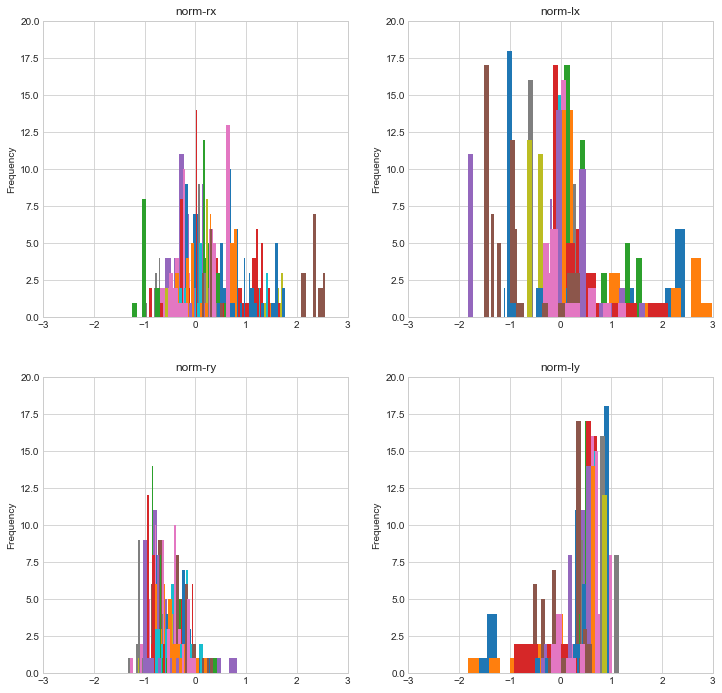

In [22]:
test_word='MARY'
fig=utils.make_histogram(samples['norm'][test_word],normed=True)

We can see distinct clustering in the 0~1 range for norm-ly, and more diffuse clustering in the -2~0 range for norm-ry.
Let's check the time series.

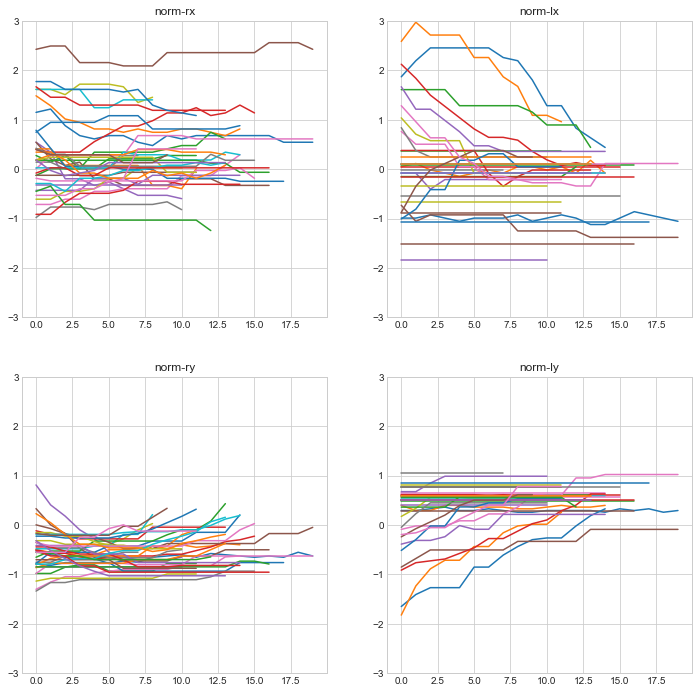

In [21]:
fig=utils.make_lines(samples['norm'][test_word])

We notice a lot of **noise for the left hand** signal, in the form of flat lines. Let's separate out those samples with flat signals.

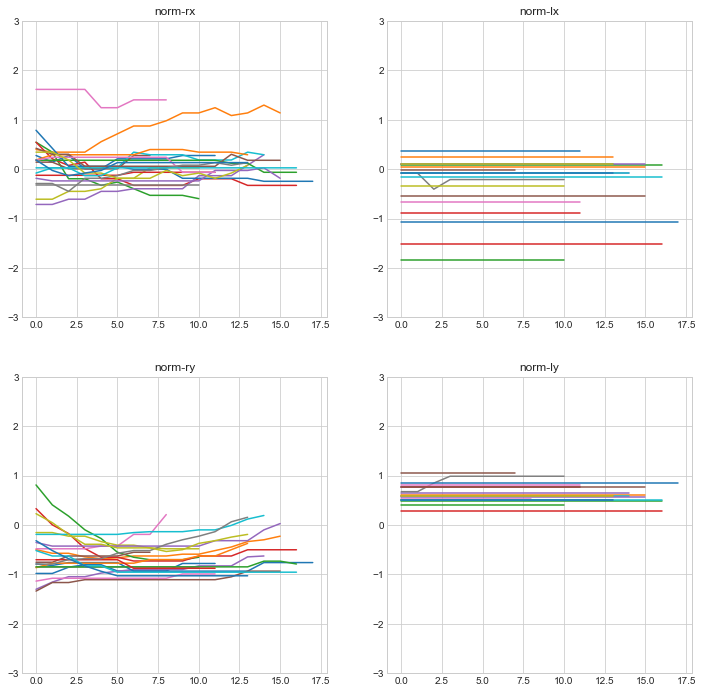

In [23]:
fig=utils.make_lines(handedness[test_word][0])

Basically the samples contain **no information** for the left hand. Now for the double-handed case.

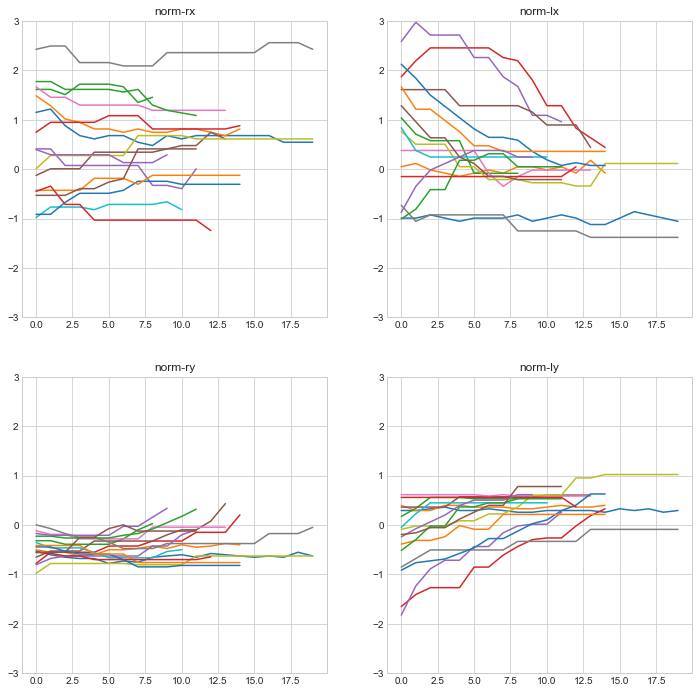

In [24]:
fig=utils.make_lines(handedness[test_word][1])

It's hard to reconcile these two distinct cases as being the same distribution. 

Thad Starner said it: ***I always like to check my assumptions, because they are often wrong.***

A simple and often neglected yet very powerful principle!

The possibility of some words having both single and double-handed versions was briefly mentioned in class but no recommendations were given, so I will list up my new assumptions. 

**Assumption:** *If the entire sample set of a word w contains signals for one hand only ==> word w is strictly a one-hand gesture.* $∀s∈S_{w} :single(s)⇒single(w)$

**Assumption:** *If the sample set of  word W contains some samples with signals for both hands and some samples with signals on one hand only ==> word W has both single- and double-handed versions.*
$∃s_{1},s_{2}∈S_{w} :single(s_{1}),double(s_{2})⇒both(w)$

**Assumption:** *Excluding such ambigious samples having multiple definitions would help make the excercise of comparing features and criteria more meaningful.*

==> I will use the below words for testing

In [25]:
test_words=words_info[(words_info.single==0) & (words_info['min']>4)].sort_values(by='count',ascending=False).head(4).index.tolist()
words_info[(words_info.single==0) & (words_info['min']>4)].sort_values(by='count',ascending=False).head(4)

,count,min,avg,max,range,spread,single,double
word,,,,,,,,
BUY,16,5,6.75,10,5,0.74,0,16
CAR,16,7,9.25,17,10,1.08,0,16
ARRIVE,15,5,10.20,17,12,1.18,0,15
HOUSE,10,9,14.00,16,7,0.50,0,10


Let's check the distributions for the highest-frequency word and **how they align across samples.**

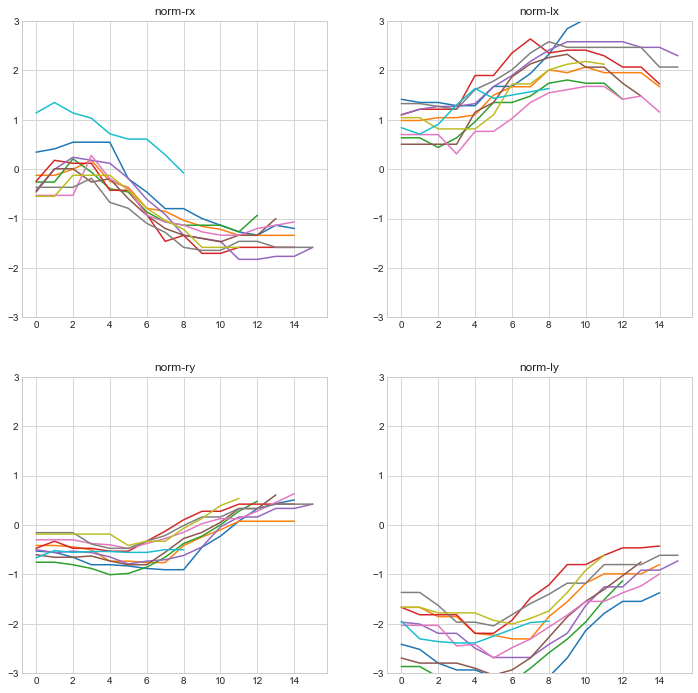

In [9]:
fig=utils.make_lines(samples['norm'][test_words[3]])

With the proposed selection criteria we seem to get suitable test words. We can even get a rough idea of the type of gesture from plotting on a x-y grid. Here, most recent samples are coloured **darker** to indicate movement.

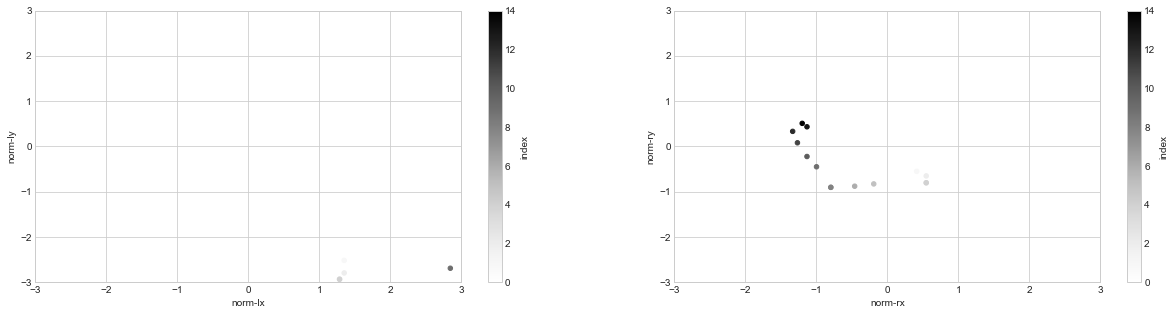

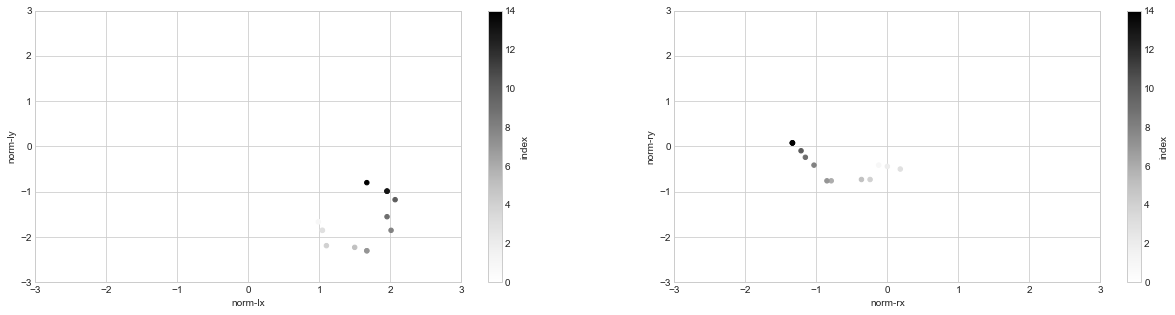

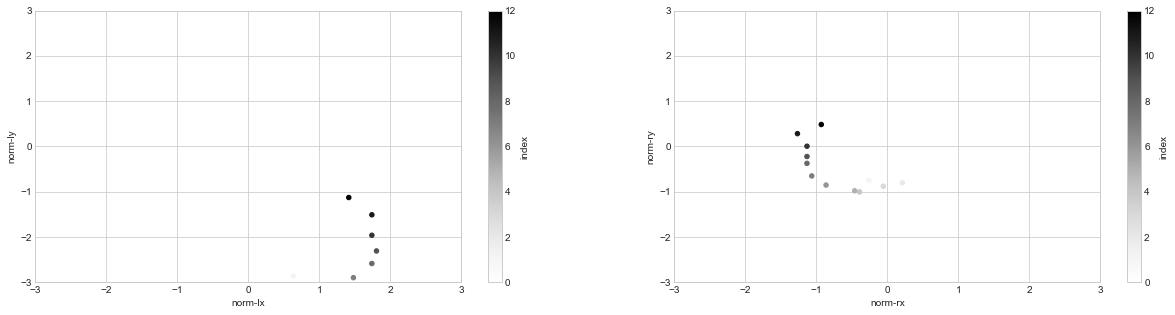

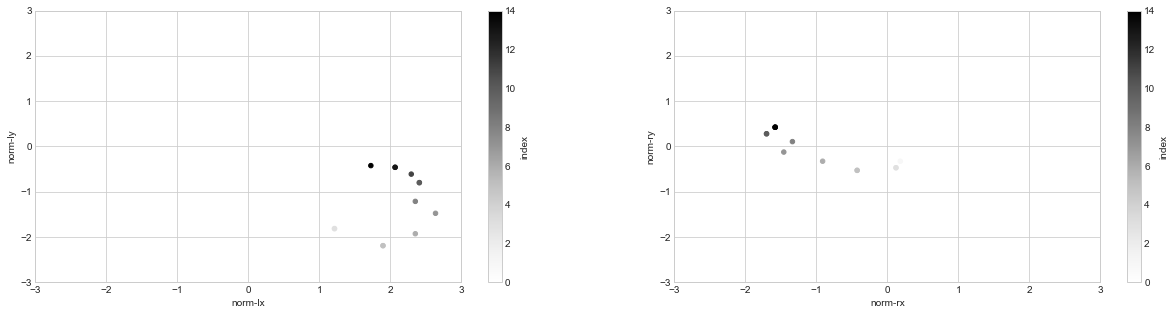

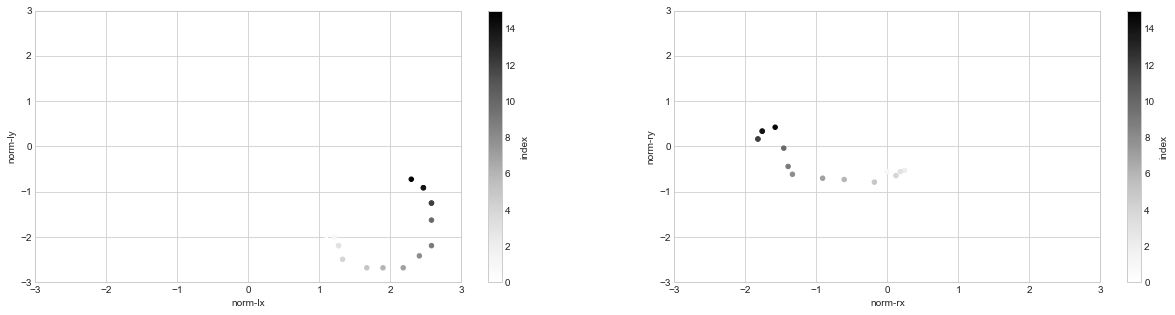

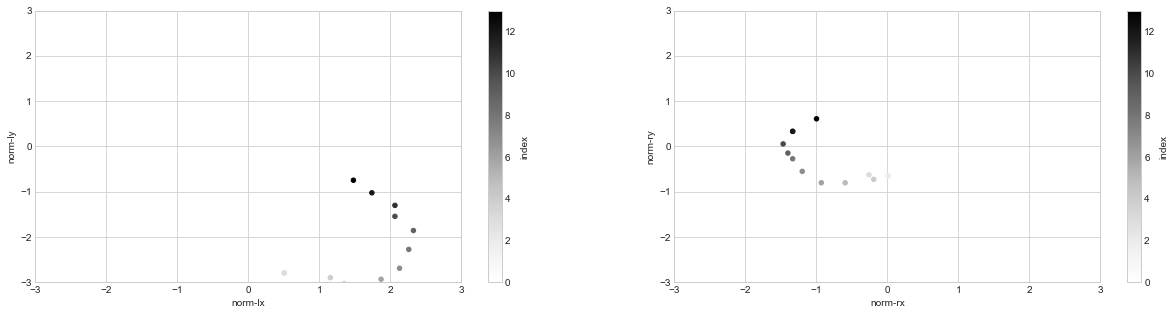

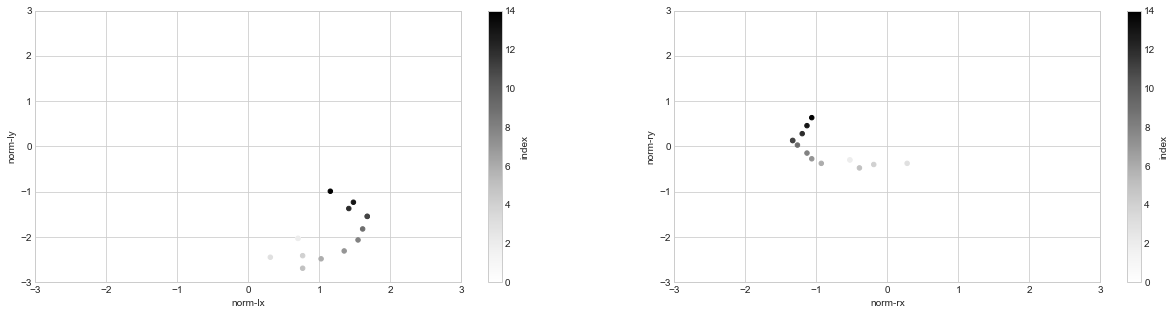

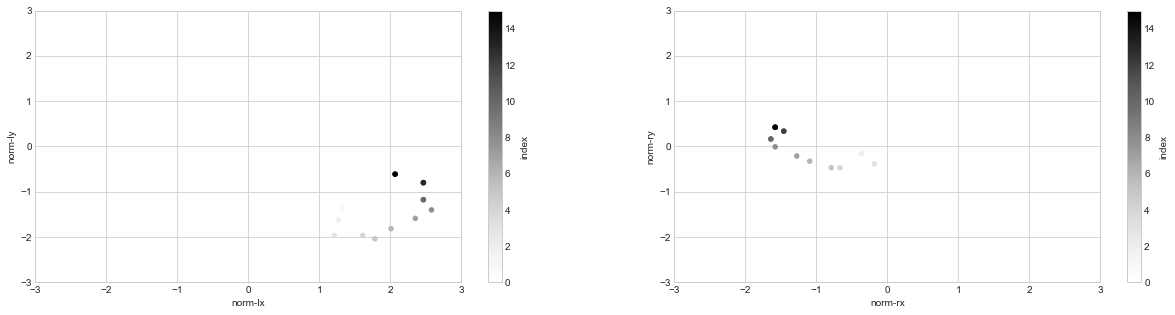

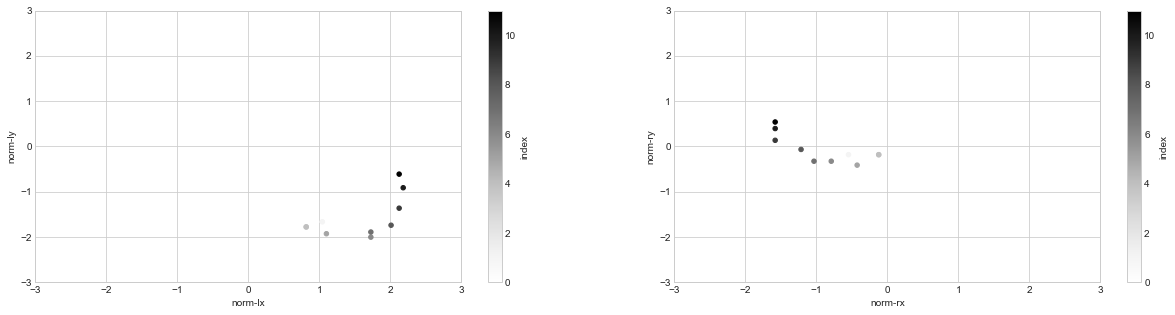

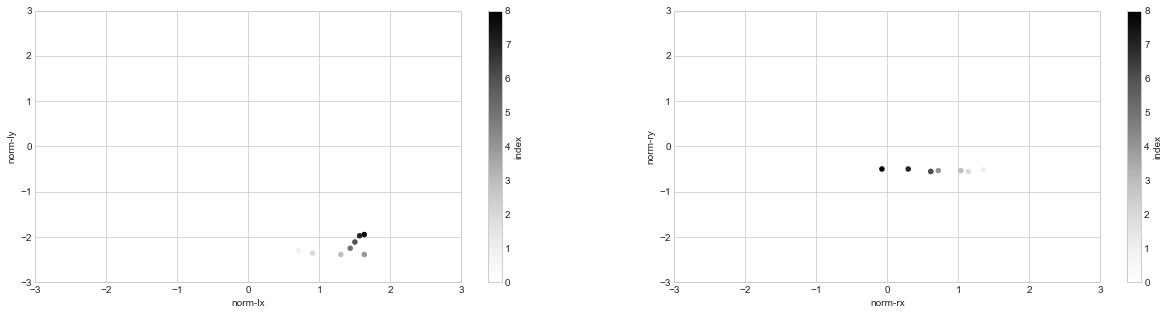

In [26]:
for sample in samples['norm'][test_words[3]]:
    fig=utils.make_scatter(sample)

**Assumption:** *Out of the four standard features 'norm' seems stricly better than 'grnd'. *

**Assumption:** *Depending on the gesture, either cartesian or polar coordinate could be preferrable. *
    
**Assumption:** *However, rather than mixing both cartesian and polar features, focusing on one seems to be the simplest and most tractable approach*

==> I will focus on cartesian coordinates for my custom features. 

I like the idea of using delta, and noticed a **potential flaw** in the original definition.

Consider the following snippet of the delta-lx feature:

In [41]:
asl.df[['grnd-lx','delta-lx']].iloc[90:110].T

video        98                                                          \
frame        90     91     92     93     94     95     96     97     98   
grnd-lx  -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00   
delta-lx   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video        99                                                          \
frame        0      1      2      3      4      5      6      7      8    
grnd-lx  -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00   
delta-lx  -7.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video                   
frame        9      10  
grnd-lx  -17.00 -17.00  
delta-lx   0.00   0.00

We're seeing a spike in delta due to rolling into a new video. 

**Assumption:** *The videos should be considered individual samples and not carry history from a previous video*

==> Delta calculation must be reset at the start of a new video.

In [27]:
custom=['cdelta']
#dimensions
hand=['right','left']
side=['r','l']
cartesian = ['x','y']
polar = ['r','theta']

custom_features={k:[k+'-'+s+c for s in side for c in cartesian] for k in custom}
idx = pd.IndexSlice
for f in custom_features['cdelta']:
    ref='norm'+f[-3:]
    asl.df[f]=asl.df[ref].diff().fillna(0)
    #this resets the features where frame=0
    asl.df.set_value(asl.df.loc[idx[:,[0]], :].index,f,0)

    
#ref='norm'
#asl.df['cpolar-rtheta']=(np.arctan2(asl.df[ref+'-rx'],asl.df[ref+'-ry']))
#asl.df['cpolar-ltheta']=(np.arctan2(asl.df[ref+'-lx'],asl.df[ref+'-ly']))
#asl.df['cpolar-rr']=np.sqrt(asl.df[ref+'-rx']**2+asl.df[ref+'-ry']**2)
#asl.df['cpolar-lr']=np.sqrt(asl.df[ref+'-lx']**2+asl.df[ref+'-ly']**2)

#custom_features['cpolar']=['cpolar-rtheta','cpolar-ltheta','cpolar-rr','cpolar-lr']
#for f in custom_features['pdelta']:
#    ref='polar'+f[-3:]
#    asl.df[f]=asl.df[ref].diff().fillna(0)
    #this resets the features where frame=0
#    asl.df.set_value(asl.df.loc[idx[:,[0]], :].index,f,0)

    

#cp=asl.df.copy()

#for f in custom_features['csum']:
#    ref='norm'+f[-3:]
#    cp.set_value(cp.loc[idx[:,[0]], :].index,ref,0)    
#    asl.df[f]=cp[ref].cumsum()
    
#custom_training={k:asl.build_training(v) for k,v in custom_features.items()}
for k,v in custom_features.items():
    training[k]=asl.build_training(v)

custom_samples=dict()
for f in custom_features:
    custom_samples[f]={k:utils.get_word(training,custom_features,f,k) for k in test_words}

In [28]:
asl.df[['grnd-lx','norm-lx','delta-lx','cdelta-lx']].iloc[90:110].T

video         98                                                          \
frame         90     91     92     93     94     95     96     97     98   
grnd-lx   -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00 -10.00   
norm-lx    -0.89  -0.89  -0.89  -0.89  -0.89  -0.89  -0.89  -0.89  -0.89   
delta-lx    0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
cdelta-lx   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video         99                                                          \
frame         0      1      2      3      4      5      6      7      8    
grnd-lx   -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00 -17.00   
norm-lx    -1.18  -1.18  -1.18  -1.18  -1.18  -1.18  -1.18  -1.18  -1.18   
delta-lx   -7.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   
cdelta-lx   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   

video                    
frame         9      10  
grnd-lx   -17.00 -17.00  
norm-lx    -1.18  -1.18  
delta-lx    0.00   0.00  
cdelta-lx   0.00   0.00

Starting frames now seem adjusted as expected.

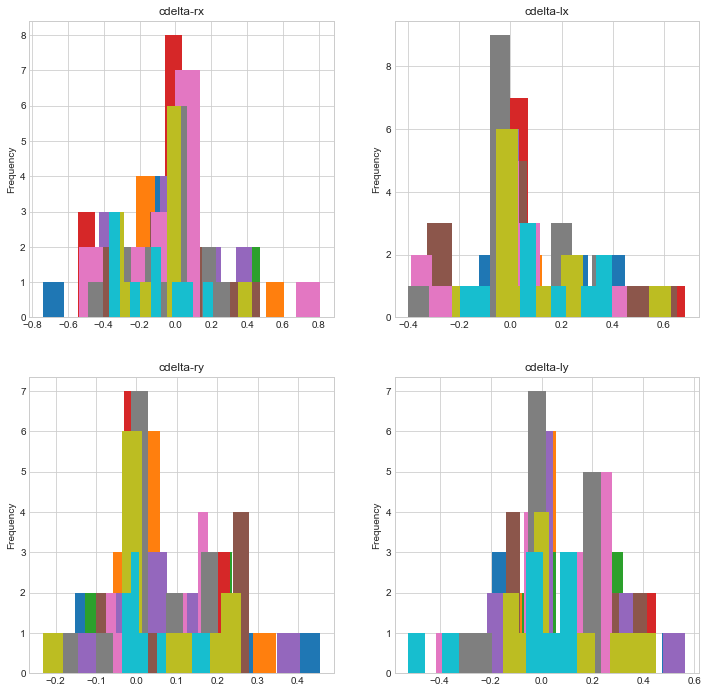

In [32]:
fig=utils.make_histogram(custom_samples['cdelta'][test_words[3]])

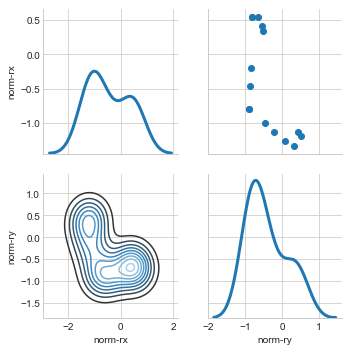

In [256]:
#g=sns.pairplot(samples['norm'][test_words[3]][0].iloc[:,0:2])
#g=sns.pairplot(samples['norm'][test_words[3]][1].iloc[:,0:2])
#samples['norm'][test_words[3]]
#training['norm']
#samples['norm'][test_words[3]][0].iloc[:,0:2]

g = sns.PairGrid(samples['norm'][test_words[3]][0].iloc[:,0:2])
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False);


**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I decided on delta of normalized cartesian coordinates. As discussed, normalizing the data seems to help against inter-person varations. Using the delta rather than position also seems to better filter out the movement, although some care is needed to avoid effects spilling over from the last frame in previous video into the first frame of a new video. At this point I want to keep the number of features constant at four. Adding more features may achieve a higher likelihood fit simply due to overfitting, which would complicate the comparison. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [33]:
import unittest
# import numpy as np

features_ground=features['grnd']
features_norm=features['norm']
features_polar=features['polar']
features_delta=features['delta']

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.013s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [35]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL



In [332]:
def fit_model(training,features_name,word,num_states,verbose=False):
    #warnings.filterwarnings("ignore", category=DeprecationWarning)
    X,lengths=training[features_name].get_word_Xlengths(word)
    m = GaussianHMM(n_components=num_states, n_iter=1000,verbose=verbose).fit(X, lengths)
    logL = m.score(X, lengths)
    return m

def score_model(model,training,word):
    X, lengths = training.get_word_Xlengths(word)
    return model.score(X,lengths)

First I will train the models on a testword, with three states, and compare the results

In [335]:
test_word=test_words[3]
n_states=3

models={k:fit_model(training,k,test_word,n_states,verbose=False) for k in ['grnd','norm','delta','cdelta']}
logL={k:score_model(v,training[k],test_word) for k,v in models.items()}
logL

{'cdelta': 270.86538980412735,
 'delta': -1507.5895342645413,
 'grnd': -1992.2796958980084,
 'norm': -210.98087357154361}

Custom Delta in the lead so far. I will now generate samples with each model and plot the result.

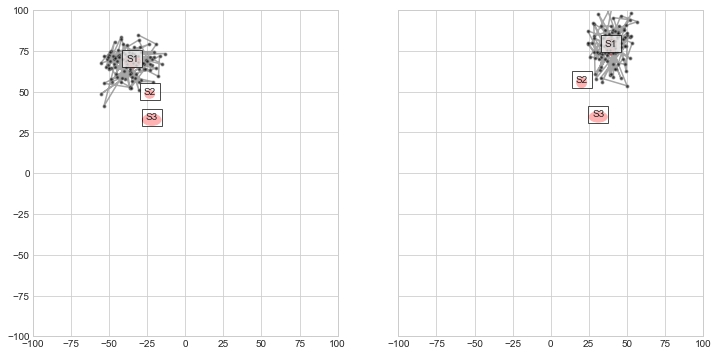

In [321]:
fig=utils.plot_states(models['grnd'],lim=100)

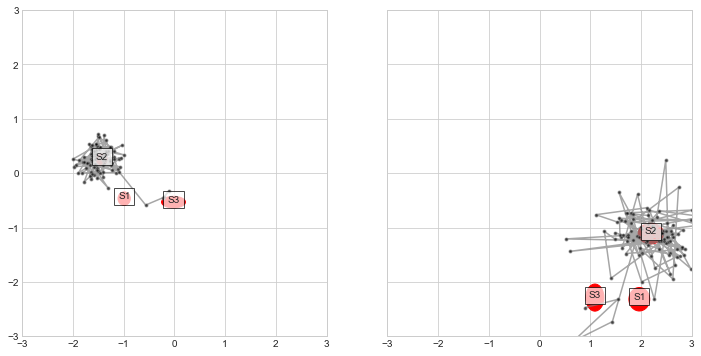

In [322]:
fig=utils.plot_states(models['norm'],lim=3)

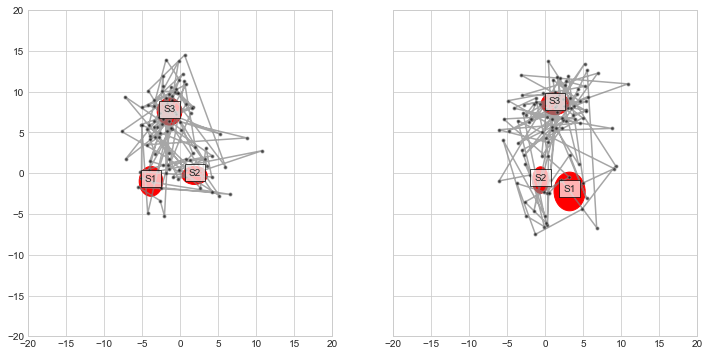

In [323]:
fig=utils.plot_states(models['delta'],lim=20)

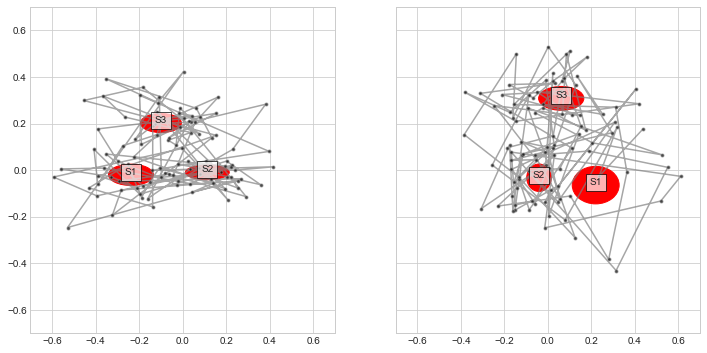

In [338]:
fig=utils.plot_states(models['cdelta'],lim=.7)

In [346]:
model=models['cdelta']
model.transmat_
means=model.means_
sigmas=[np.sqrt(np.diag(covars)) for covars in model.covars_]
sigmas

[array([ 0.207,  0.091,  0.216,  0.161]),
 array([ 0.202,  0.063,  0.113,  0.118]),
 array([ 0.188,  0.082,  0.208,  0.102])]

Next I will fit the custom model for number of states from 2,15 and plot the resulting logL

In [348]:
vs_states={k:fit_model(training,'cdelta',test_words[3],k) for k in range(2,16)}

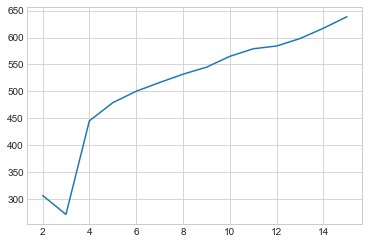

In [354]:
vs_logL={k:score_model(v,training['cdelta'],test_word) for k,v in vs_states.items()}

plt.plot([k for k,v in vs_logL.items()],[v for k,v in vs_logL.items()])

#[i for i in range(1,vs_states[2][0].n_components)]

Unsurprisingly, the logL increases with increasing number of states. What about accuracy?

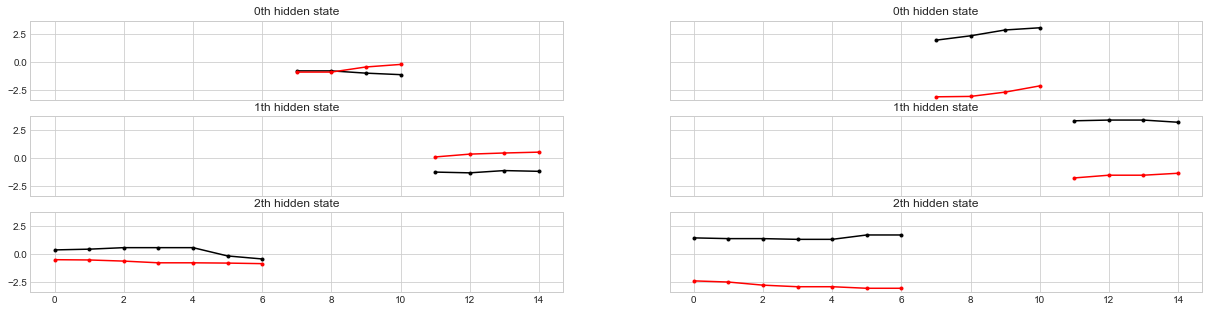

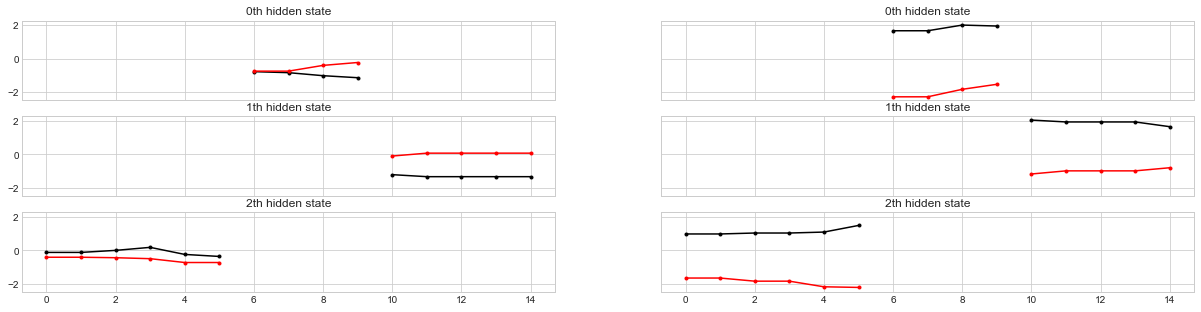

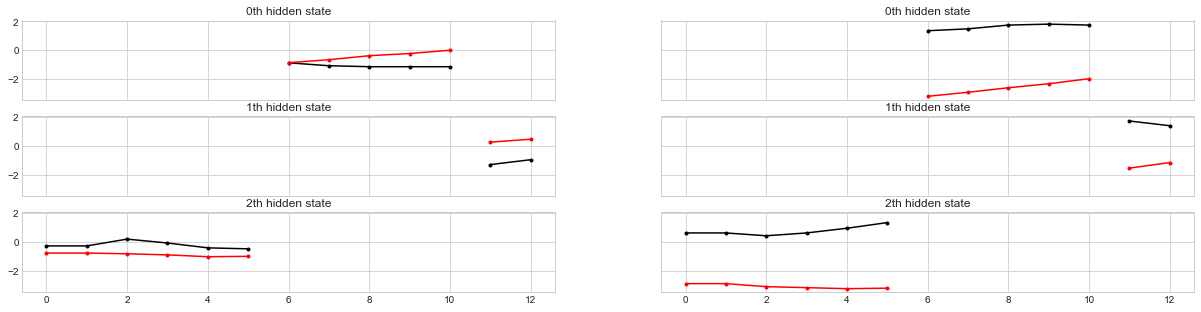

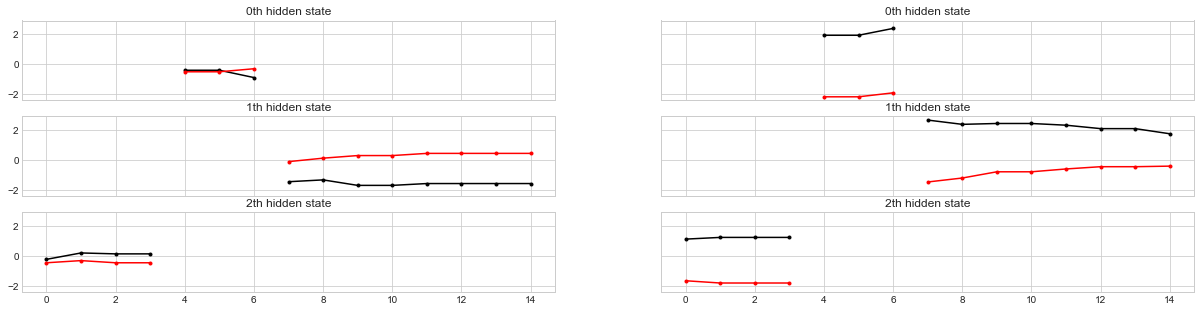

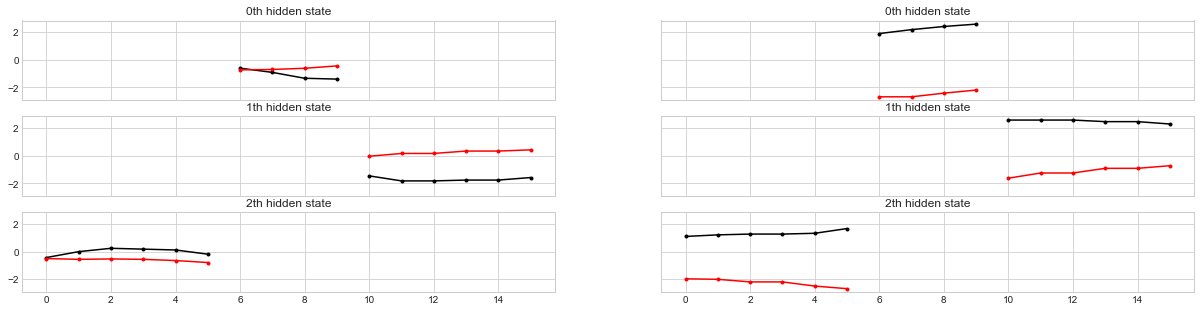

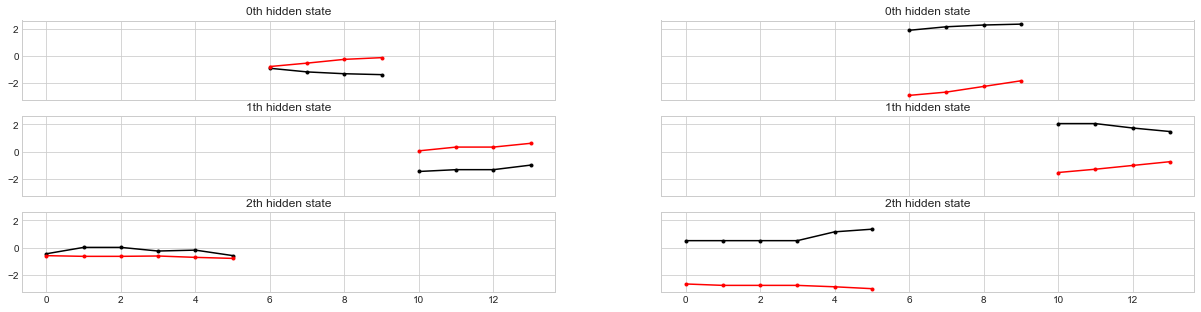

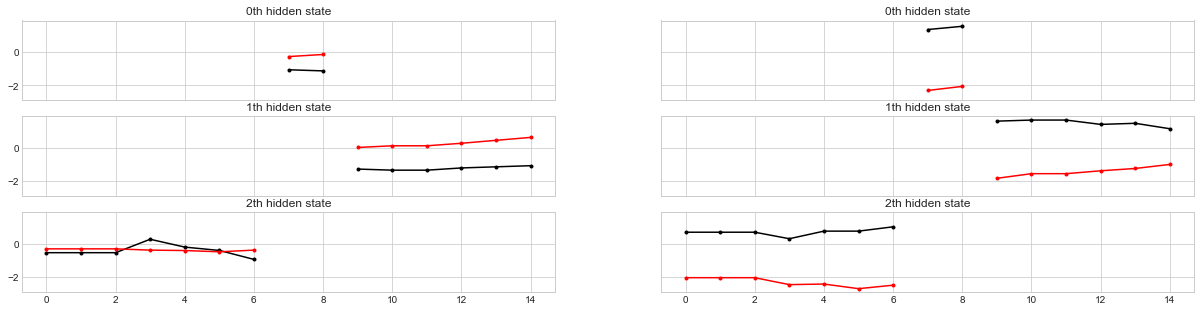

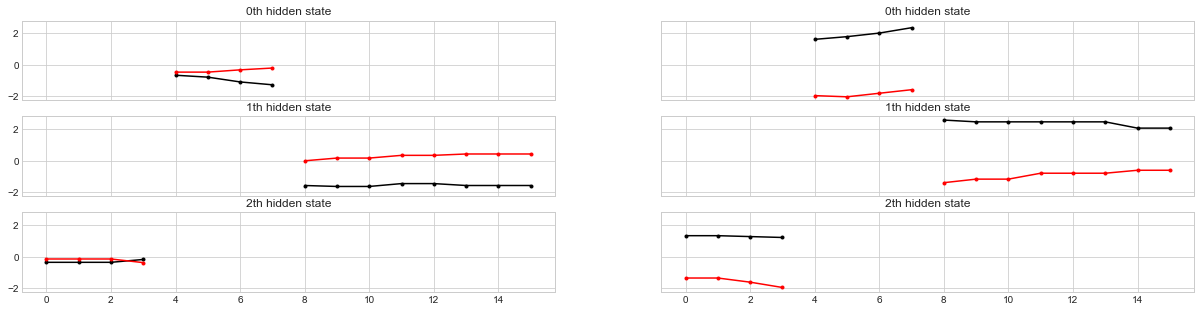

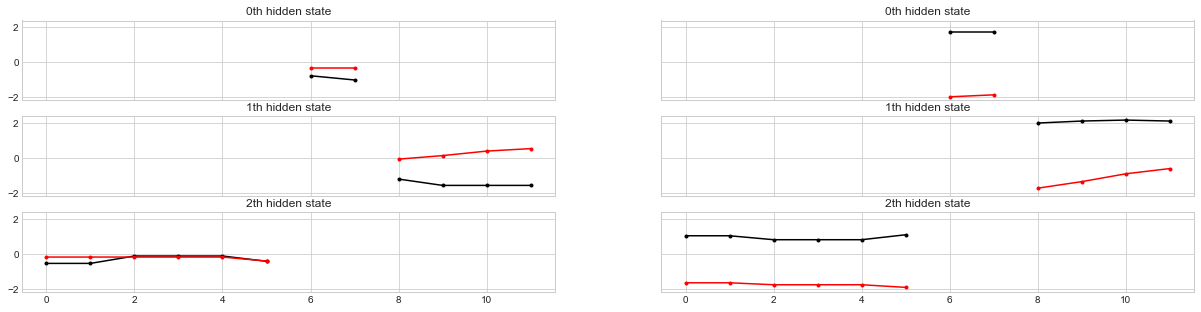

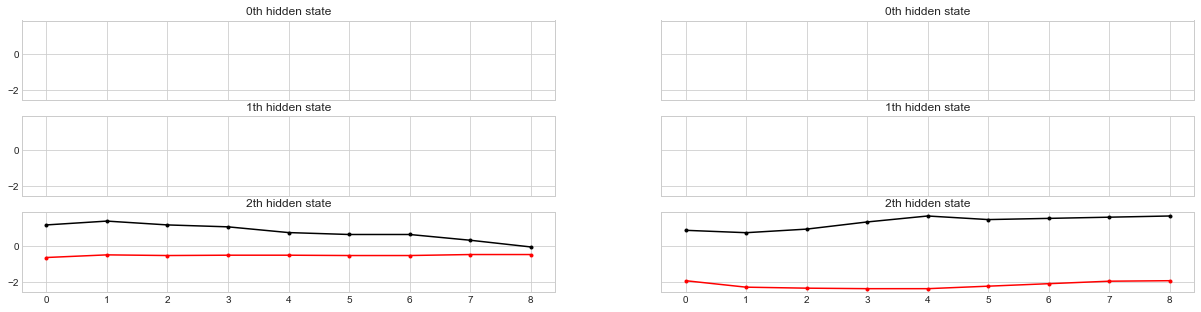

In [298]:
for s in samples['norm'][words[3]]:
    utils.plot_states(vs_states[3][0],s)

In [323]:
#reload(utils)
#utils.show_model_stats(word, vs_states[10][0])
vs_states[5][0].transmat_
#for k,v in model.items():
#    print(k)
#    utils.show_model_stats(word, v)

array([[ 0.84,  0.  ,  0.16,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.41,  0.59,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.04,  0.73,  0.23],
       [ 0.08,  0.  ,  0.16,  0.  ,  0.76]])

In [191]:
np.set_printoptions(precision=2,suppress=True)
for k,v in model.items():
    print(k)
    print(v.transmat_)
#assert sum(sum(model.transmat_))==3.0

grnd
[[ 0.88  0.12  0.  ]
 [ 0.    1.    0.  ]
 [ 0.02  0.12  0.86]]
norm
[[ 1.    0.    0.  ]
 [ 0.29  0.71  0.  ]
 [ 0.    0.15  0.85]]
delta
[[ 0.81  0.19  0.  ]
 [ 0.07  0.73  0.2 ]
 [ 0.22  0.    0.78]]
polar
[[ 0.87  0.    0.13]
 [ 0.    1.    0.  ]
 [ 0.02  0.18  0.8 ]]


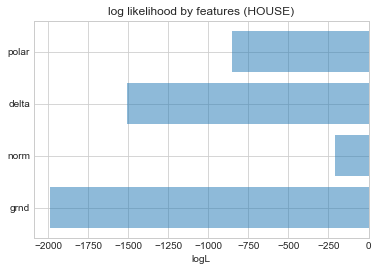

In [192]:

#comparison=
comparison=pd.DataFrame.from_dict(logL,orient='index').rename(columns={0:word})
#df.join(pd.DataFrame.from_dict(logL,orient='index')).rename(columns={0:word})
fig=utils.likelihood_barchart(logL,word)
#make heatmap

In [193]:
comparison

,HOUSE
grnd,-1992.28
norm,-210.98
delta,-1507.59
polar,-855.11


And the resulting **state graph** is below

In [31]:
m=model.transmat_
dott=utils.dot_hmm(m)
print(dott)

0->0:0.9895975175021443
0->1:0.010402482497855773
0->2:1.3762951059976813e-21
1->0:0.0219085349542947
1->1:0.9780914650457053
1->2:8.050201765625027e-26
2->0:0.06635384845842962
2->1:0.052863596961018514
2->2:0.8807825545805519
digraph G {
node [fontname=helvetica, fontsize=10];
edge [fontname=helvetica, fontsize=9];
state_0 [label=state_0, penwidth=2, shape=square];
state_1 [label=state_1, penwidth=2, shape=square];
state_2 [label=state_2, penwidth=2, shape=square];
state_0 -> state_0  [label="0.99", penwidth=1];
state_0 -> state_1  [label="0.01", penwidth=1];
state_0 -> state_2  [label="0.00", penwidth=1];
state_1 -> state_0  [label="0.02", penwidth=1];
state_1 -> state_1  [label="0.98", penwidth=1];
state_1 -> state_2  [label="0.00", penwidth=1];
state_2 -> state_0  [label="0.07", penwidth=1];
state_2 -> state_1  [label="0.05", penwidth=1];
state_2 -> state_2  [label="0.88", penwidth=1];
}



![text](model.PNG)

In [28]:
#hidden_states = model['norm'].predict(X)
assert np.shape(X[:,0])==np.shape(hidden_states)
X[:,0]

In [44]:
models=dict()
features_names=['grnd','polar','delta','norm','custom']
df=pd.DataFrame(index=features_names)
from importlib import reload
import utils
reload(utils)
comparison=dict()

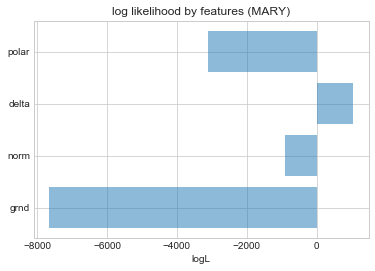

In [39]:
comparison[word]=df.join(pd.DataFrame.from_dict(logL,orient='index')).rename(columns={0:word})

model grnd on IX: 3 states, logL -8.6e+03
model polar on IX: 3 states, logL -3.8e+03
model delta on IX: 3 states, logL +2e+02
model norm on IX: 3 states, logL -1.2e+03
model custom on IX: 3 states, logL -1.6e+03


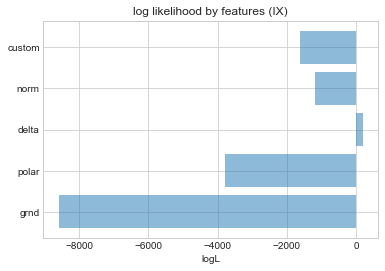

In [45]:
word=words[0]
model,logL=utils.likelihood_comparison(train_a_word,features,word)
fig=utils.likelihood_barchart(logL,word)
models[word]=model
comparison[word]=df.join(pd.DataFrame.from_dict(logL,orient='index')).rename(columns={0:word})

model grnd on JOHN: 3 states, logL -1.8e+04
model polar on JOHN: 3 states, logL -7.6e+03


C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
C:\Users\Administrator\Anaconda3\envs\aind\lib\site-packages\hmmlearn\base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


model delta on JOHN: 3 states, logL +5.9e+02
model norm on JOHN: 3 states, logL -1.8e+03
model custom on JOHN: 3 states, logL -3.1e+03


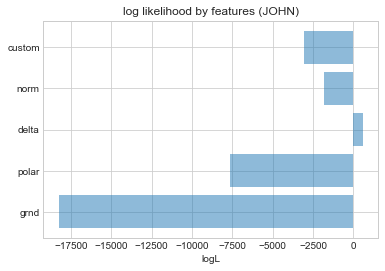

In [46]:
word=words[1]
model,logL=utils.likelihood_comparison(train_a_word,features,word)
fig=utils.likelihood_barchart(logL,word)
models[word]=model
comparison[word]=df.join(pd.DataFrame.from_dict(logL,orient='index')).rename(columns={0:word})

The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [85]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features['delta']) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

NameError: name 'train_a_word' is not defined

In [260]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, custom_features['cdelta']) 
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.78560152  1.92579509  1.88221066 -2.68915598]
variance =  [0.1161804  0.07808317 0.07879657 0.07542306]

hidden state #1
mean =  [0.43330253 1.18439959 0.97778643 2.37549857]
variance =  [0.02853555 0.35903029 0.04357431 3.01080788]

hidden state #2
mean =  [ 0.64875929  1.82353359  0.57082867 -1.00114063]
variance =  [0.02241773 0.18054854 0.05569911 5.86986803]

logL = -91.30780676442124


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [45]:
%matplotlib inline

In [301]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        


In [154]:
variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
variance

array([[  9.501,  13.389,  16.725,  22.511],
       [ 10.876,   4.888,   4.417,  10.577],
       [ 10.442,  11.012,  13.05 ,   7.277]])

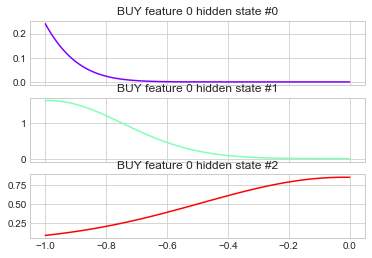

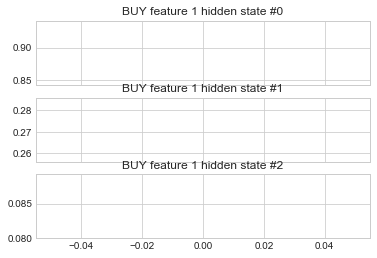

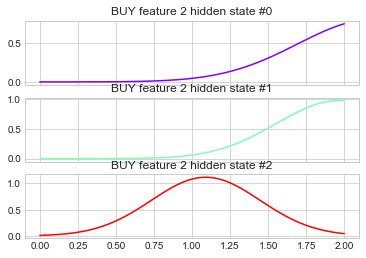

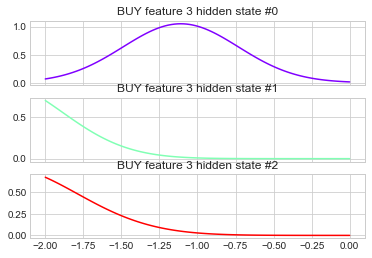

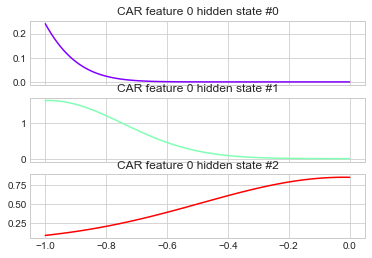

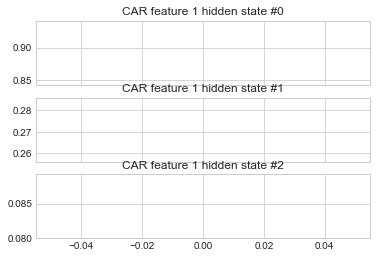

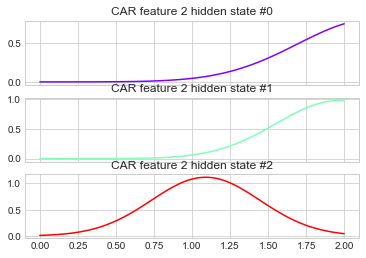

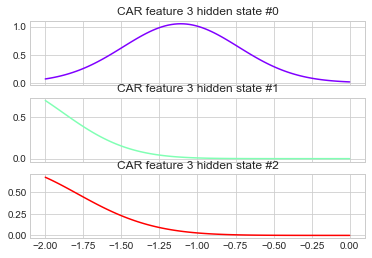

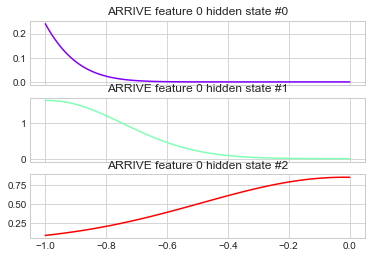

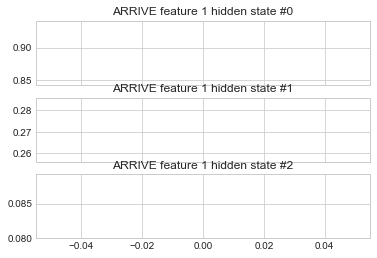

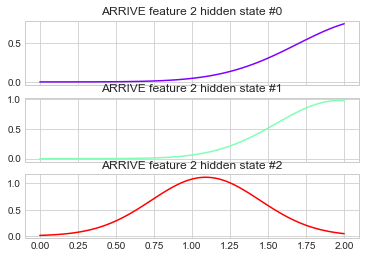

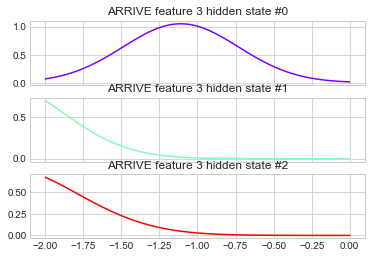

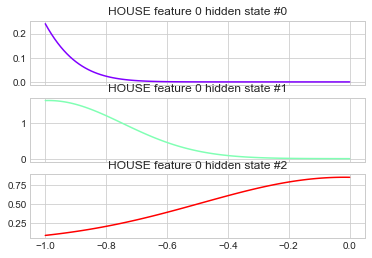

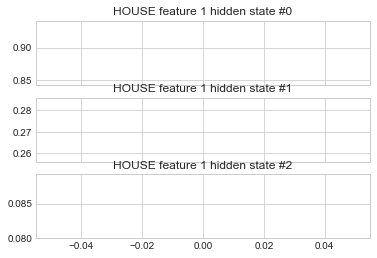

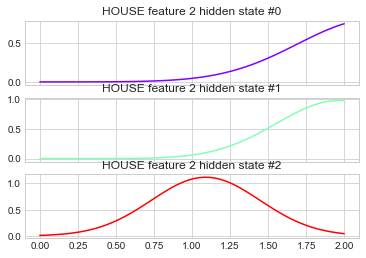

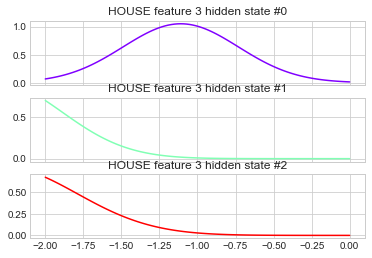

In [302]:
for word in words:
    visualize(word, model['norm'])

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [303]:
from my_model_selectors import SelectorConstant

#training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1


word = words[3] # Experiment here with different words
t=training['norm']
m = SelectorConstant(t.get_all_sequences(), t.get_all_Xlengths(), word, n_constant=3,verbose=True).select()
print("Number of states trained in model for {} is {}".format(word, m.n_components))

model created for HOUSE with 3 states
Number of states trained in model for HOUSE is 3


         1        -459.4752             +nan
         2        -250.8413        +208.6339
         3        -216.7998         +34.0415
         4        -212.6155          +4.1843
         5        -212.2902          +0.3253
         6        -212.0478          +0.2425
         7        -211.8284          +0.2194
         8        -211.6326          +0.1957
         9        -211.4664          +0.1662
        10        -211.3334          +0.1330
        11        -211.2323          +0.1011
        12        -211.1580          +0.0743
        13        -211.1043          +0.0536
        14        -211.0660          +0.0384
        15        -211.0385          +0.0275
        16        -211.0188          +0.0197
        17        -211.0046          +0.0142
        18        -210.9942          +0.0104
        19        -210.9866          +0.0076


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [306]:
from sklearn.model_selection import KFold

#training = asl.build_training(features_custom) # Experiment here with different feature sets
#word = 'VEGETABLE' # Experiment here with different words
word_sequences = t.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[4 5 6 7 8 9] Test fold indices:[0 1 2 3]
Train fold indices:[0 1 2 3 7 8 9] Test fold indices:[4 5 6]
Train fold indices:[0 1 2 3 4 5 6] Test fold indices:[7 8 9]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [307]:
words_to_train = words#['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [110]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
verbose=False

#training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
t=custom_training['csum']
sequences = t.get_all_sequences()
Xlengths = t.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

NameError: name 'words_to_train' is not defined

In [309]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC
verbose=False
#training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = t.get_all_sequences()
Xlengths = t.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for BUY with 3 states with time 2.0826168001254928 seconds
Training complete for CAR with 4 states with time 1.6859234866032722 seconds
Training complete for ARRIVE with 7 states with time 1.8567334554206383 seconds
Training complete for HOUSE with 5 states with time 1.5040480317029221 seconds


In [310]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC
verbose=False
#training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = t.get_all_sequences()
Xlengths = t.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word,verbose=verbose, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for BUY with 3 states with time 0.10370172202135564 seconds
Training complete for CAR with 3 states with time 0.08251222717608186 seconds
Training complete for ARRIVE with 3 states with time 0.04792809230391981 seconds
Training complete for HOUSE with 3 states with time 0.06279316914096 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [42]:
from asl_test_model_selectors import TestSelectors
import unittest
from warnings import filterwarnings
filterwarnings('ignore')
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 42.850s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [113]:
from my_model_selectors import SelectorCV
#features=features_custom
def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

#models = train_all_words(features'norm', SelectorConstant)
#print("Number of word models returned = {}".format(len(models)))

##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [44]:
test_set = asl.build_test(features)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [105]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [134]:
from my_model_selectors import SelectorCV

# TODO Choose a feature set and model selector
#features = features # change as needed
#model_selector = SelectorConstant # change as needed
model_selector = SelectorCV
f=features['norm']
f=custom_features['cpolar']

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(f, model_selector)
test_set = asl.build_test(f)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6741573033707865
Total correct: 58 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *GO                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *SOMETHING-ONE CAN                               JOHN CAN GO CAN
   12: *SHOULD *WHAT *GO1 CAN                                        JOHN CAN GO CAN
   21: *LIKE *CAR *BUY1 *IX-1P *GIVE1 *CAR *NEW *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *LIKE LIKE *GIVE1 *LIKE *LIKE                                 JOHN LIKE IX IX IX
   28: *ANN LIKE *LIKE *LIKE *LIKE                                   JOHN LIKE IX IX IX
   30: *IX-1P LIKE *LOVE *LIKE IX                                    JOHN LIKE IX IX IX
   36: *NOT *OLD *IX *WOMAN LIKE *LIKE                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *WOMAN *OLD *SUE LOVE                                    JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [115]:
df=pd.DataFrame.from_dict(probabilities[0],orient='index').rename(columns={0:'logL'})
words_info.join(df).sort_values(by='logL',ascending=False)

,count,min,avg,max,range,spread,single,double,logL
word,,,,,,,,,
JOHN,113,5,10.52,27,22,2.09,67,46,84.34
IX,52,3,10.06,28,25,2.49,34,18,83.02
POSS,11,5,8.09,14,9,1.11,6,5,67.58
FUTURE,15,4,9.40,18,14,1.49,5,10,58.86
GO,12,5,8.17,14,9,1.10,3,9,46.28
WOMAN,7,8,13.57,22,14,1.03,2,5,44.53
LIKE,12,4,6.75,12,8,1.19,9,3,42.92
VISIT,11,8,10.73,14,6,0.56,2,9,42.34
MARY,37,8,13.95,20,12,0.86,21,16,32.21


In [116]:
model_selector = SelectorCV
f=features['delta']
models = train_all_words(f, model_selector)
test_set = asl.build_test(f)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *HAVE *GIVE1 *TEACHER                                    JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *MARY *MARY WONT *MARY *CAR *GO *SHOULD *MARY                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *JOHN *MARY                                       JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *MARY *NOT IX IX                                         JOHN LIKE IX IX IX
   36: MARY *FUTURE *JOHN *NOT *GIVE3 *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *WHO *SEE *APPLE                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX *FINISH HOUSE       

In [350]:
df=pd.DataFrame.from_dict(probabilities[0],orient='index').rename(columns={0:'logL'})
words_info.join(df).sort_values(by='logL',ascending=False)

,count,min,avg,max,range,spread,single,double,logL
word,,,,,,,,,
JOHN,113,5,10.52,27,22,2.09,67,46,-19.74
IX,52,3,10.06,28,25,2.49,34,18,-52.87
SOMETHING-ONE,10,7,10.40,14,7,0.67,5,5,-67.01
GO,12,5,8.17,14,9,1.10,3,9,-67.16
POSS,11,5,8.09,14,9,1.11,6,5,-68.16
HAVE,5,7,9.20,11,4,0.43,0,5,-72.35
LOVE,14,6,11.43,22,16,1.40,1,13,-101.00
FUTURE,15,4,9.40,18,14,1.49,5,10,-102.45
MARY,37,8,13.95,20,12,0.86,21,16,-117.60


In [319]:
model_selector = SelectorDIC
f=features['norm']
models = train_all_words(f, model_selector)
test_set = asl.build_test(f)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: *MARY WRITE *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *NEW *JOHN CAN                                           JOHN CAN GO CAN
   12: *SHOULD *HAVE *GO1 CAN                                        JOHN CAN GO CAN
   21: *LIKE *NEW *HAVE *IX-1P *CAR *BLAME *CHICKEN *WRITE           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX LIKE *LIKE *LIKE IX                                       JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *SHOOT LIKE *LOVE *LIKE *MARY                                 JOHN LIKE IX IX IX
   36: *LEAVE *NOT *YESTERDAY *VISIT LIKE *JOHN                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *LEAVE *FUTURE1 *VEGETABLE LOVE                          JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [348]:
#guess=max(probabilities[0], key=lambda key: probabilities[0][key])
df=pd.DataFrame.from_dict(probabilities[0],orient='index').rename(columns={0:'logL'})
words_info.join(df).sort_values(by='logL',ascending=False)

,count,min,avg,max,range,spread,single,double,logL
word,,,,,,,,,
MARY,37,8,13.95,20,12,0.86,21,16,-41.28
JOHN,113,5,10.52,27,22,2.09,67,46,-45.48
SOMETHING-ONE,10,7,10.40,14,7,0.67,5,5,-46.26
HAVE,5,7,9.20,11,4,0.43,0,5,-48.94
GO,12,5,8.17,14,9,1.10,3,9,-55.62
IX,52,3,10.06,28,25,2.49,34,18,-56.55
FUTURE,15,4,9.40,18,14,1.49,5,10,-63.67
POSS,11,5,8.09,14,9,1.11,6,5,-68.16
VISIT,11,8,10.73,14,6,0.56,2,9,-82.88


**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [34]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

NameError: name 'unittest' is not defined

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()